# Part 1 -  Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

#### Import File

In [318]:
import pandas as pd
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


#### Aggregate login counts based on 15 min intervals

In [319]:
# Resample the time series dataframe in 15-minute intervals then aggregate it by count.
df_login = df.resample(rule = '15min', on = 'login_time').count()

# Clean up dataframe
df_login.columns = ['count']
df_login.reset_index(inplace=True)

df_login.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


#### Inspect the data

In [320]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
login_time    9788 non-null datetime64[ns]
count         9788 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.0 KB


In [321]:
df_login.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


From the 2 summary tables, we know there is no missing data. The values in the columns make sense. 
* Count consists of numerical values. 
* The min for hour is 0 which translates to midnight while the max for the hour is 23 which translates to 11 PM. 
* The min for night is 0, meaning not night time, and max of 1, meaning night time. 

#### Explore Underlying Patterns of Demand

To get the most information out of the datetime object of the login, the date and hour component can be extracted from it. Date can be converted to day of the week while hour infers day or night.

In [322]:
# Extracting day of week and hour
df_login['day'] = df_login['login_time'].dt.day_name()
df_login['hour'] = df_login['login_time'].dt.hour

# If the hour falls in the nightime, night = 1
df_login['night'] = df_login['hour'].apply(lambda x: 1 if x>=12 else 0)

df_login.head()

,login_time,count,day,hour,night
0,1970-01-01 20:00:00,2,Thursday,20,1
1,1970-01-01 20:15:00,6,Thursday,20,1
2,1970-01-01 20:30:00,9,Thursday,20,1
3,1970-01-01 20:45:00,7,Thursday,20,1
4,1970-01-01 21:00:00,1,Thursday,21,1


First, we can see which day is the most popular in terms of login counts. This can be summarized by the total number of logins and the average daily count of logins for that day.

In [323]:
df_day = df_login.groupby('day').sum()[['count']]
df_day.columns = ['total_count']
df_day['avg_count'] = df_login.groupby('day').mean()['count']

df_day.sort_values('total_count', ascending = False)

,total_count,avg_count
day,,
Saturday,19377,13.456250
Sunday,18167,12.615972
Friday,15208,10.561111
Thursday,11960,8.794118
Wednesday,10339,7.692708
Tuesday,9268,6.895833
Monday,8823,6.213380


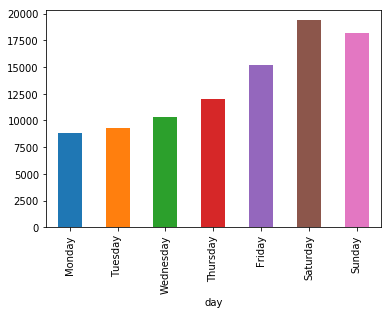

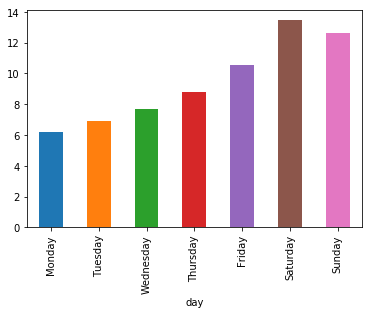

In [324]:
# Visualization of the Table
import matplotlib.pyplot as plt

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day.total_count.reindex(order).plot(kind = 'bar')
plt.show()

df_day.avg_count.reindex(order).plot(kind='bar')
plt.show()

According to the table, it looks like most people use the rideshare app during the weekends with the highest login count in terms of total count and average daily count on Saturday.

We can also identify popular time for logins in terms of total login count and average daily login count for the hour. 

In [325]:
df_hour = df_login.groupby('hour').sum()[['count']]
df_hour.columns = ['total_count']
df_hour['avg_count'] = df_login.groupby('hour').mean()['count']

df_hour.sort_values('total_count', ascending = False).head(5)

,total_count,avg_count
hour,,
22,6607,16.193627
1,6317,15.482843
23,6058,14.848039
0,5993,14.688725
2,5800,14.215686


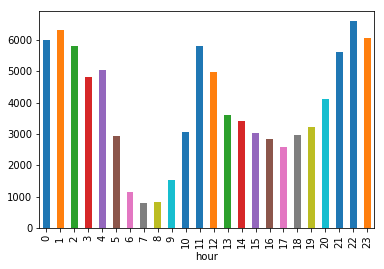

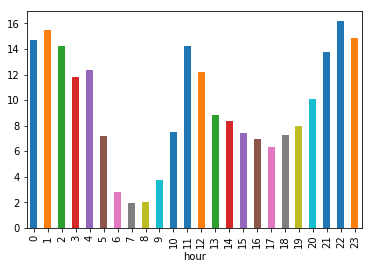

In [326]:
# Visualization of the Table
import matplotlib.pyplot as plt

df_hour.total_count.plot(kind = 'bar')
plt.show()

df_hour.avg_count.plot(kind='bar')
plt.show()

The top 5 hours of with the highest demand is from 10pm - 2am. There also seems to be an increase in demand during lunch time (11am - 12pm).

We can then combine both the day of the week and time of day to figure out which time (day or night) is most popular for each day of the week.

In [327]:
df_night = df_login.groupby(['day', 'night']).sum()[['count']]
df_night['avg_count'] = df_login.groupby(['day', 'night']).mean()['count']
df_night.columns = ['total_count', 'avg_count']
df_night.sort_values(['day', 'total_count'], ascending = False)

total_count  avg_count
day       night                        
Wednesday 1             5769   8.584821
          0             4570   6.800595
Tuesday   1             5307   7.897321
          0             3961   5.894345
Thursday  1             6807   9.893895
          0             5153   7.668155
Sunday    0            10351  14.376389
          1             7816  10.855556
Saturday  0            10217  14.190278
          1             9160  12.722222
Monday    1             4918   7.025714
          0             3905   5.423611
Friday    1             9284  12.894444
          0             5924   8.227778

On most weekdays, there's higher demand during night hours. In our case, night hours is 12pm - 11:59pm. The only exception to this is Saturday and Sunday in which there is higher demand during day hours.

Below is a visualization for the average daily demand for each hour.

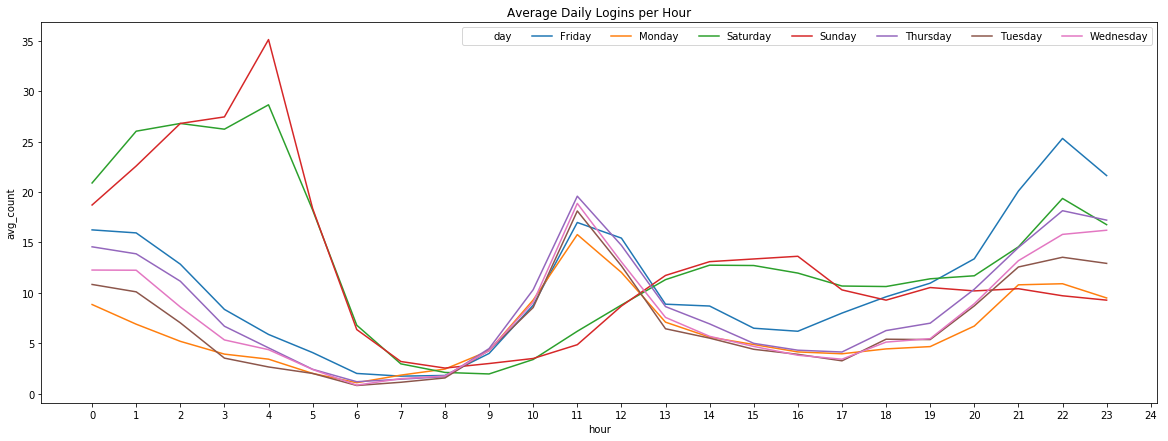

In [328]:
df_hour = df_login.groupby(['day', 'hour']).mean()[['count']]
df_hour.columns = ['avg_count']
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_hour.reset_index(inplace=True)

import seaborn as sns
plt.subplots(figsize=(20,7))
sns.lineplot(x= "hour", y='avg_count', data = df_hour, hue = 'day')
plt.legend(loc="upper right", ncol=8)
plt.title("Average Daily Logins per Hour")
plt.xticks(range(0,25))

#display plot
plt.show()

By looking more detailed into the hours, we realize that the higher demand during morning hours of Saturday and Sunday peak at 4 am.

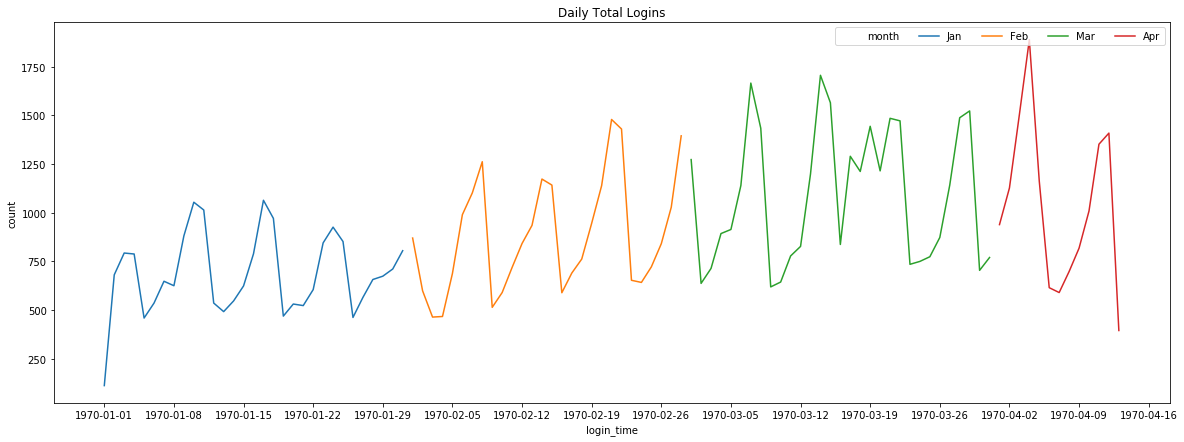

In [329]:
# Time Series of Logins
import matplotlib.dates as mdates

#resampling df to daily intervals
df_daily = df.resample("24H", on="login_time").count()

#cleaning up df
df_daily.columns = ['count']
df_daily.reset_index(inplace=True)

#extracting months
df_daily["month"] = df_daily["login_time"].dt.month
df_daily["month"] = df_daily["month"].map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr"})

#plotting df
plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="login_time", y="count", data=df_daily, hue="month")
ax.legend(loc="upper right", ncol=5)
ax.set(title="Daily Total Logins")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))

#display plot
plt.show()

The demand had increased slightly in the beginning of April, but it decreased towards the mid month.

# Part 2 ‑ Experiment and metrics design 

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: 
    * how you will implement the experiment 
    * what statistical test(s) you will conduct to verify the significance of the observation 
    * how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Answer    
Drivers being exclusive means that there is a lack of drivers in both cities. The goal of the toll reimbursement is to encourage drivers to be available in both cities and increase supply. Therefore, the metrics we choose should be those that are affected by low supply and high demand.

1. **Daily Number of Toll Crossings**: This refers to the number of times the driver crosses the toll bridge.
2. **Daily Average Wait Time**: This refers to the difference in the time the rider sends the request and the time the driver arrives.
3. **Daily Number of Cancellations**: Drivers see the location of pick up after they accept the ride. If the rider is too far from the driver, drivers tend to cancel the ride.

*Note: Metrics regarding cost of ride and number of surges were not choosen due to inability to contain affects within the groups. For example, if the reimbursement causes increase in supply, it would then lower the number of surges and stabilize the ride price for all drivers, not just those in the treatment group.*

For this experiment, we will conduct A/B testing in which only half of the drivers in the area will receive toll reimbursements (treatment group) and the other half will not (control group). We will study the program for 100 days. The metrics should be measured both 50 days before and 50 days after the implementation of the reimbursement program for both the treatment group and control group. One tail hypothesis testing will be conducted for all metrics.

* *First Null Hypothesis*: There is no difference in the daily number of toll crossings between the treatment group and the control group.
* *First Alternative Hypothesis*: The treatment group has a higher daily number of toll crossings than the control group.


* *Second Null Hypothesis*: There is no difference in the daily average wait time between the treatment group and the control group.
* *Second Alternative Hypothesis*: The treatment group has a lower daily average wait time than the control group.


* *Third Null Hypothesis*: There is no difference in the daily number of cancellations between the treatment group and the control group.
* *Third Alternative Hypothesis*: The treatment group has a lower daily number of cancellations than the control group.


We will conduct 2 hypothesis tests per hypothesis to test the effect before and after the implementation. We will set the significance level to be 5%. We want to fail to reject the null hypothesis before the implementation then reject the null hypothesis after the implementation. To simulate the null hypothesis, we can combine the data for both groups into one large dataset. Then create a sampling distribution of the difference in means between the 2 groups by permuting the large dataset then splitting it into 2 groups and finding the mean of both groups. To calculate the p-value, find the probability of getting positive values for the difference in means for where we expect the metric to be higher for the treatment group while finding the probability for negative values for the difference in means where we expect the metric to be lower for the treatment group.
If p-value is less than 5%, the null hypothesis can be rejected and the difference is considered to be statistically significant.

If we disprove the null hypothesis for all the three metrics, then we have proven that the reimbursement program works. Now, we can see if it is worth reimbursing toll costs by comparing the gains in revenue. As another back plan, we can also look into the impact of reverting back to unsubsidizing toll.

# Part 3 ‑ Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. 

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. 
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

Data description 
* city: city this user signed up in 
* phone: primary device for this user 
* signup_date: date of account registration; in the form ‘YYYY MM DD’ 
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’ 
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup 
* avg_rating_by_driver: the rider’s average rating over all of their trips 
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 
* surge_pct: the percent of trips taken with surge multiplier > 1 
* avg_surge: The average surge multiplier over all of this user’s trips 
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up 
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise 
* weekday_pct: the percent of the user’s trips occurring during a weekday

### Data Cleaning

In [330]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [331]:
# Load JSON file and convert into pandas df
import pandas as pd
import json

#save file to memory
file = open("ultimate_data_challenge.json", "r")
dataset = file.read()
file.close()

#load file as JSON
data = json.loads(dataset)

#create df from JSON dataset
df = pd.DataFrame(data)

#parse dates
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


A user is considered active if a user takes at least one trip during its first 30 days. The active column will follow this logic.

In [332]:
df['active'] = (df['trips_in_first_30_days'] > 0) * 1
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1


        Proportion
active            
0           0.3078
1           0.6922


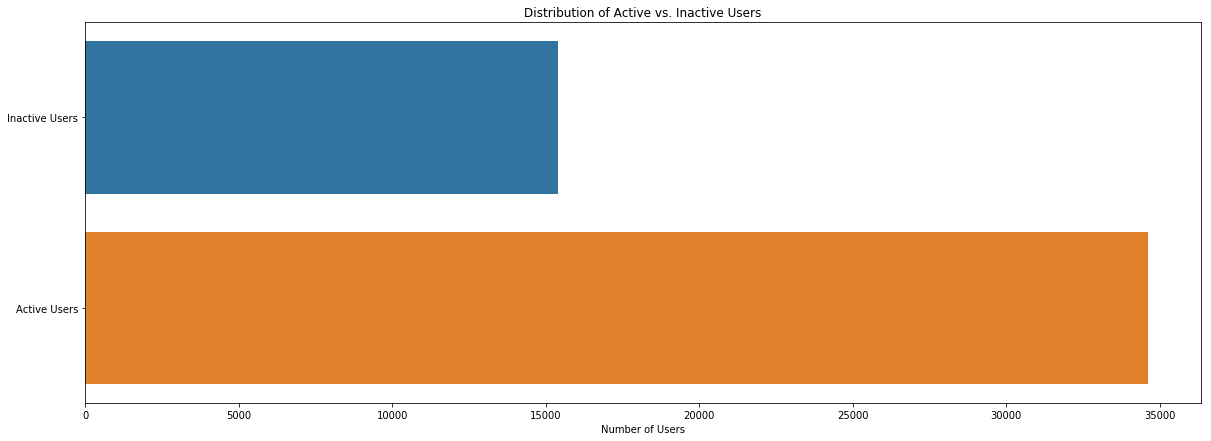

In [333]:
# Calculate proportion of retained vs not retained
stats = df.groupby('active').count()[['avg_dist']]
stats.columns = ['Proportion']
stats['Proportion'] = stats['Proportion']/len(df)
print(stats)

plt.subplots(figsize=(20,7))
ax = sns.countplot(y=df["active"])
ax.set(title="Distribution of Active vs. Inactive Users", \
       ylabel="", xlabel="Number of Users")
ax.set_yticklabels(["Inactive Users", "Active Users"])
plt.show()

### Building Predictive Model

#### Target Variable
In order to predict if a user will retain in its sixth month, we first create the sixth_month_active column, in which the value should be true if their most recent trip was in June.

In [334]:
df['sixth_month_active'] = (df['last_trip_date'].dt.month== 6) * 1
df[['signup_date', 'last_trip_date', 'sixth_month_active']].head()

,signup_date,last_trip_date,sixth_month_active
0,2014-01-25,2014-06-17,1
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


#### Data Preprocessing
Before building the model, we should inspect on how to deal with missing values. 3 columns seem to be missing values: avg_rating_by_driver, avg_rating_of_driver, and phone.

In [335]:
df.isna().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
active                    False
sixth_month_active        False
dtype: bool

In [336]:
df[['avg_rating_by_driver', 'avg_rating_of_driver', 'phone']].head()

,avg_rating_by_driver,avg_rating_of_driver,phone
0,5.0,4.7,iPhone
1,5.0,5.0,Android
2,5.0,4.3,iPhone
3,4.9,4.6,iPhone
4,4.9,4.4,Android


In [337]:
df[['avg_rating_by_driver', 'avg_rating_of_driver', 'phone']].describe()

,avg_rating_by_driver,avg_rating_of_driver
count,49799.000000,41878.000000
mean,4.778158,4.601559
std,0.446652,0.617338
min,1.000000,1.000000
25%,4.700000,4.300000
50%,5.000000,4.900000
75%,5.000000,5.000000
max,5.000000,5.000000


To fill in the missing values in for the ratings, we will use the sample average for the column since they are numerical values.

In [338]:
df['avg_rating_by_driver'].fillna((df['avg_rating_by_driver'].mean()), inplace=True)
df['avg_rating_of_driver'].fillna((df['avg_rating_of_driver'].mean()), inplace=True)
df.isna().any()

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
active                    False
sixth_month_active        False
dtype: bool

The phone column describe the type of phone the user has. Having a null value for this column may mean that the app does not recognize the phone. The app seems to only recognize iPhones and Androids. We will categorize null values as "Other" instead.

In [339]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [340]:
df['phone'].fillna("Other", inplace=True)
df.isna().any()

avg_dist                  False
avg_rating_by_driver      False
avg_rating_of_driver      False
avg_surge                 False
city                      False
last_trip_date            False
phone                     False
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
active                    False
sixth_month_active        False
dtype: bool

Models can only be trained on numerical values and categorical so we need to convert all of those that are not. 3 of the columns need to be addressed. The columns containing datetime objects will be dropped from the model since we have extracted the information needed from those fields.

In [341]:
df.info()
df = df.drop(columns = ["last_trip_date", "signup_date"])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active                    50000 non-null int32
sixth_month_active        50000 non-null int32
dtypes: bool(1), datetime64[ns](2), float64(6), int32(2), int64(1), object(2)
memory usage: 4.6+ MB


In [342]:
# preprocessing
df["ultimate_black_user"] = (df["ultimate_black_user"] * 1).astype("category")
df["active"] = df["active"].astype("category")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
phone                     50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null category
weekday_pct               50000 non-null float64
active                    50000 non-null category
sixth_month_active        50000 non-null int32
dtypes: category(2), float64(6), int32(1), int64(1), object(2)
memory usage: 3.7+ MB


The data has now completed preprocessing. 
#### Split data into train and test set

In [343]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df[df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

display(X_train.head())
display(y_train.head())

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active
45139,5.21,4.7,5.0,1.04,Winterfell,iPhone,4.4,14,1,75.6,1
9901,2.25,4.7,4.3,1.08,Astapor,iPhone,10.0,11,0,60.0,1
26038,3.11,4.6,4.8,1.57,Astapor,iPhone,28.6,5,0,14.3,1
49163,1.32,5.0,4.5,1.00,Astapor,iPhone,0.0,1,0,50.0,1
38957,4.36,4.7,3.2,1.00,Winterfell,Android,0.0,17,1,40.0,1


45139    1
9901     0
26038    0
49163    0
38957    0
Name: sixth_month_active, dtype: int32

#### Build Pipeline for the model
1. Standardize all numerical features
2. Convert categorical variables into dummy variables
3. Set up Logistic Regression Classification algorithm
4. Tune hyperparameters using GridSearchCV

In [345]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline for numeric features
numeric_features = ["avg_dist", "avg_rating_by_driver", "avg_rating_of_driver", \
                    "avg_surge", "surge_pct", "trips_in_first_30_days", "weekday_pct"]
numeric_transformer = [("scaler", StandardScaler())]
numeric_transformer = Pipeline(numeric_transformer)

# Pipeline for categorical features
categorical_features = ["city", "phone", "ultimate_black_user", "active"]
categorical_transformer = [("encoder", OneHotEncoder())]
categorical_transformer = Pipeline(categorical_transformer)

# Preprocess data
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features), \
                  ("cat", categorical_transformer, categorical_features)])

#incorporating the random forest estimator
pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("lr", LogisticRegression())])

#grid search parameters
params = {"lr__penalty" : ['l1', 'l2'],
          "lr__C" : np.logspace(0, 4, 10)}

#fitting the pipeline to the grid search
cv = GridSearchCV(pipeline, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")

Best parameters: {'lr__C': 2.7825594022071245, 'lr__penalty': 'l2'}
Training accuracy score from tuned model:        71.3%


For the metrics, we use accuracy in terms of classification and F1 score to take account false positives and false negatives. Now that we have trained our classification model, we will see how it performs on the test set. The model accuracy when applied to the test model actually improved. 

In [346]:
from sklearn import metrics

y_pred = cv.predict(X_test)

test_accuracy = metrics.accuracy_score(y_test, y_pred)
test_f1_score = metrics.f1_score(y_test, y_pred)

print(f"Model accuracy: {test_accuracy*100:.2f}%")
print(f"Model F1 Score: {test_f1_score:.2f}")

Model accuracy: 72.04%
Model F1 Score: 0.55


In [347]:
#replicating numeric_transformer of our pipeline
num_cols = df[numeric_features].columns
num_cols = num_cols.tolist()

#replicating categorical_transformer of our pipeline
cat_cols = pd.get_dummies(df[categorical_features]).columns
cat_cols = cat_cols.tolist()

#the column names are added together
cols = num_cols + cat_cols

pipeline = Pipeline(steps=[("pre", preprocessor), \
                           ("lr", LogisticRegression(C=2.782556, penalty='l2'))])
pipeline.fit(X_train, y_train)
feature_coef = pd.DataFrame({'Feature': cols, 'Coefficient': pipeline.named_steps['lr'].coef_[0]})
feature_coef = feature_coef.sort_values(by='Coefficient', ascending = False)
feature_coef

,Feature,Coefficient
8,city_King's Landing,0.825014
5,trips_in_first_30_days,0.509797
12,phone_iPhone,0.484352
14,ultimate_black_user_1,0.309433
15,active_0,0.072265
4,surge_pct,0.065423
2,avg_rating_of_driver,-0.014957
3,avg_surge,-0.036253
6,weekday_pct,-0.044747
1,avg_rating_by_driver,-0.060500


It appears that those in King's Landing, iPhone users, and Ultimate Black users are more likely to be retained in the 6th month. The higher number of trips in the first 30 days also indicate retention. 

On the contrary, those in Astapor, Android users, and non Ultimate Black users are less likely to be retained in the 6th month. Therefore, to increase retention, the team should do the following:
* look into ways to encourage riders in Astapor to get on the app
* look into issues and bugs in the Android interface that may be decreasing retention in Android users 
* research more into the demographics of Ultimate Black users to see if they can convert more users into using Ultimate Black
* provide as many promotions as possible in the first 30 days for new users to increase number of rides within that time period